## EDA

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('../data/zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [4]:
df.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64

In [6]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['SizeRank','RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted.set_index('time',inplace=True)
    melted.dropna(inplace=True)
    return melted

In [7]:
melt_data = melt_data(df)
melt_data.head()

,SizeRank,RegionID,RegionName,City,State,Metro,CountyName,value
time,,,,,,,,
1996-04-01,1,84654,60657,Chicago,IL,Chicago,Cook,334200.0
1996-04-01,2,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,235700.0
1996-04-01,3,91982,77494,Katy,TX,Houston,Harris,210400.0
1996-04-01,4,84616,60614,Chicago,IL,Chicago,Cook,498100.0
1996-04-01,5,93144,79936,El Paso,TX,El Paso,El Paso,77300.0


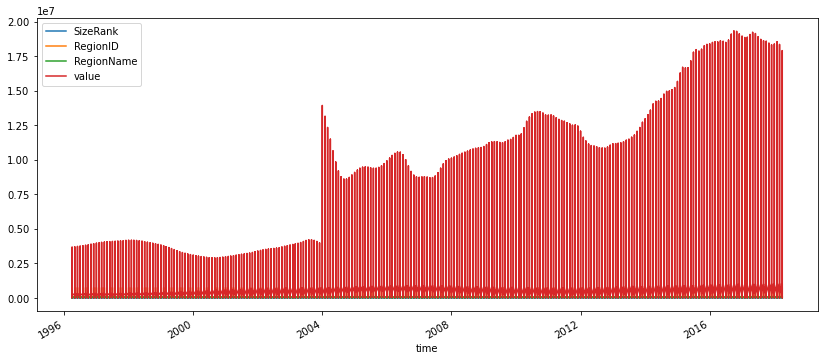

In [8]:
melt_data.plot(figsize = (14, 6));

In [9]:
def avg_melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted_1 = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted_1['time'] = pd.to_datetime(melted_1['time'], infer_datetime_format=True)
    melted_1 = melted_1.dropna(subset=['value'])
    return melted_1.groupby('time').aggregate({'value':'mean'})

In [10]:
avg_melt_data = avg_melt_data(df)
avg_melt_data.head()

,value
time,
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312


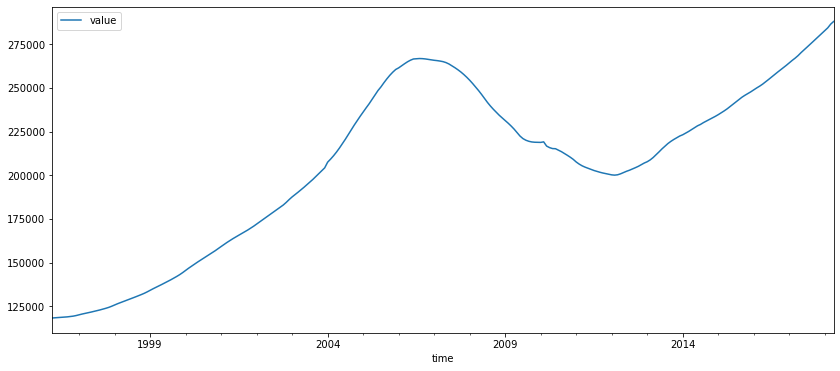

In [11]:
avg_melt_data.plot(figsize = (14, 6));

## Differencing and Stationarity 

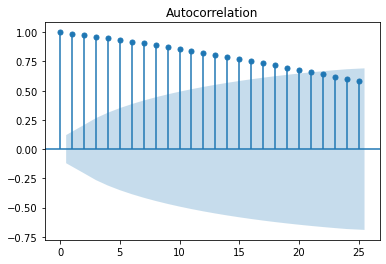

In [12]:
# Autocorrelation Function plot decreases very slowly, meaning values of time series are correlated and heavily affected by past values. 
# Assuming positive autocorrelation, meaning the mean will change over time as the value increases, future values will also increase, 
# which makes the series non-stationary. 
plot_acf(avg_melt_data['value']);

In [13]:
# After running Dickey-Fuller test, we see that the p_value is 33%, we need to make the series stationary by differencing. 
adfuller(avg_melt_data)[1]

0.3390815439412529

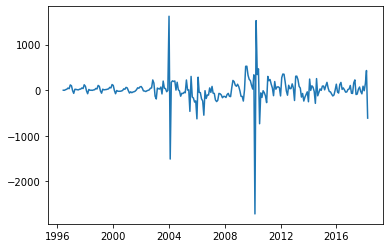

In [14]:
diff_avg = avg_melt_data.diff().diff()
plt.plot(diff_avg);

In [15]:
adfuller(diff_avg.dropna())[1]

0.0

In [16]:
diff_avg

,value
time,
1996-04-01,NaN
1996-05-01,NaN
1996-06-01,-1.541947
1996-07-01,-2.733119
1996-08-01,11.539024
...,...
2017-12-01,86.789377
2018-01-01,-12.721592
2018-02-01,149.887930


## Nevada

In [18]:
# Function to turn dataset from Wide Format to Long Format and return only the state Nevada 
def melt_data_nv(df):
    melted = pd.melt(df, id_vars=['SizeRank','RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted.set_index('time',inplace=True)
    melted.dropna(inplace=True)
    return melted[melted['State'] == 'NV']

In [19]:
# Turning the function into Nevada Dataframe
df_nv = melt_data_nv(df)
df_nv.head()

,SizeRank,RegionID,RegionName,City,State,Metro,CountyName,value
time,,,,,,,,
1996-04-01,116,95804,89108,Las Vegas,NV,Las Vegas,Clark,102500.0
1996-04-01,174,95817,89121,Las Vegas,NV,Las Vegas,Clark,106800.0
1996-04-01,196,95813,89117,Las Vegas,NV,Las Vegas,Clark,165100.0
1996-04-01,263,95785,89052,Henderson,NV,Las Vegas,Clark,185700.0
1996-04-01,310,95819,89123,Las Vegas,NV,Las Vegas,Clark,144000.0


In [22]:
df_nv['CountyName'].value_counts()

Clark          15769
Washoe          4822
Douglas         1946
Carson City     1325
Nye              426
Lyon             386
Elko             152
Name: CountyName, dtype: int64

In [23]:
df_nv['Metro'].value_counts()

Las Vegas               15769
Reno                     4822
Gardnerville Ranchos     1946
Carson City              1325
Pahrump                   426
Fernley                   386
Elko                      152
Name: Metro, dtype: int64

In [24]:
# We have a very small p-value 
adfuller(df_nv['value'])

(-10.534601263843584,
 8.968529555390564e-19,
 47,
 24778,
 {'1%': -3.430613942916506,
  '5%': -2.861656654731722,
  '10%': -2.566832091910836},
 661255.5270010391)

In [56]:
zipcode = 95804

In [57]:
ts = pd.DataFrame({'ds':df_nv[df_nv['RegionID'] == zipcode].index, 'y':df_nv[df_nv['RegionID'] == zipcode]['value']})
ts.head()

,ds,y
time,,
1996-04-01,1996-04-01,102500.0
1996-05-01,1996-05-01,102500.0
1996-06-01,1996-06-01,102500.0
1996-07-01,1996-07-01,102600.0
1996-08-01,1996-08-01,102700.0


## Facebook Prophet Model

In [ ]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [26]:
m = Prophet(yearly_seasonality=True, interval_width=0.95)
prophet_model = m.fit(ts)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:
# Create a dataframe with predictions of the next 5 years 
future = m.make_future_dataframe(periods=60, freq='M')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1996-04-01,149917.093991,-164468.398816,461910.527275,149917.093991,149917.093991,483.468004,483.468004,483.468004,483.468004,483.468004,483.468004,0.0,0.0,0.0,150400.561995
1,1996-05-01,150335.336377,-155153.771274,463879.134312,150335.336377,150335.336377,634.607911,634.607911,634.607911,634.607911,634.607911,634.607911,0.0,0.0,0.0,150969.944288
2,1996-06-01,150767.520176,-167571.202008,450210.967632,150767.520176,150767.520176,671.542267,671.542267,671.542267,671.542267,671.542267,671.542267,0.0,0.0,0.0,151439.062444
3,1996-07-01,151185.762563,-166160.133124,455209.937962,151185.762563,151185.762563,218.198725,218.198725,218.198725,218.198725,218.198725,218.198725,0.0,0.0,0.0,151403.961288
4,1996-08-01,151617.946362,-181902.545135,462185.239221,151617.946362,151617.946362,159.581052,159.581052,159.581052,159.581052,159.581052,159.581052,0.0,0.0,0.0,151777.527415


In [28]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
320,2022-11-30,433092.236619,76327.558028,805348.222913,226795.104523,625607.866179,95.861721,95.861721,95.861721,95.861721,95.861721,95.861721,0.0,0.0,0.0,433188.098339
321,2022-12-31,435136.170234,88711.578710,793199.037787,223951.069471,633609.289400,-278.590739,-278.590739,-278.590739,-278.590739,-278.590739,-278.590739,0.0,0.0,0.0,434857.579496
322,2023-01-31,437180.103850,53277.591470,802870.669108,221286.518472,641661.103942,-1527.102507,-1527.102507,-1527.102507,-1527.102507,-1527.102507,-1527.102507,0.0,0.0,0.0,435653.001343
323,2023-02-28,439026.237438,75785.428936,821825.201900,218894.719530,648903.068677,3288.762405,3288.762405,3288.762405,3288.762405,3288.762405,3288.762405,0.0,0.0,0.0,442314.999843
324,2023-03-31,441070.171054,86726.426602,808881.695601,216305.667072,657230.517525,1187.389761,1187.389761,1187.389761,1187.389761,1187.389761,1187.389761,0.0,0.0,0.0,442257.560814


In [29]:
forecast[['ds', 'yhat']]

,ds,yhat
0,1996-04-01,150400.561995
1,1996-05-01,150969.944288
2,1996-06-01,151439.062444
3,1996-07-01,151403.961288
4,1996-08-01,151777.527415
...,...,...
320,2022-11-30,433188.098339
321,2022-12-31,434857.579496
322,2023-01-31,435653.001343
323,2023-02-28,442314.999843


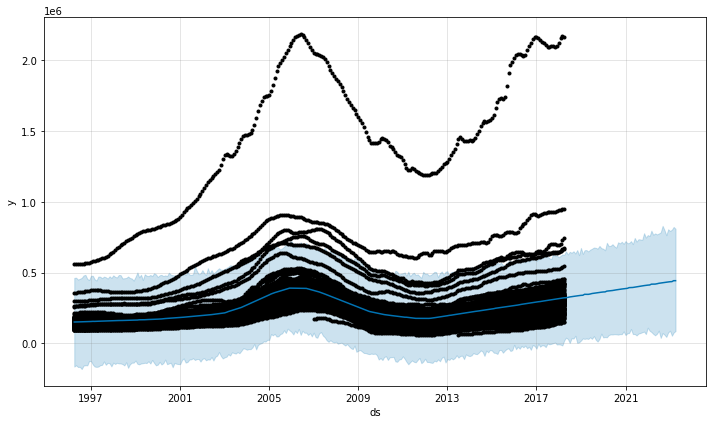

In [30]:
fig1 = m.plot(forecast)

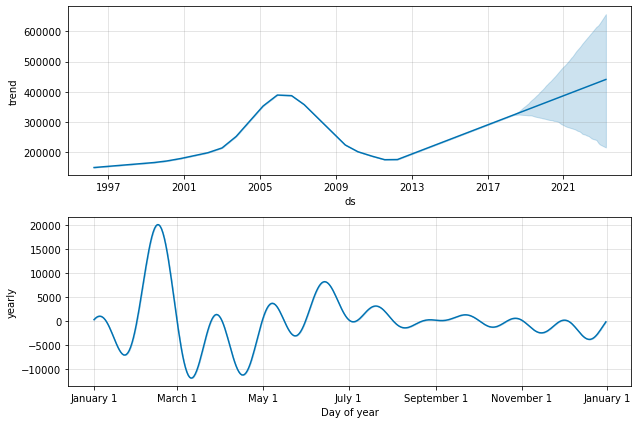

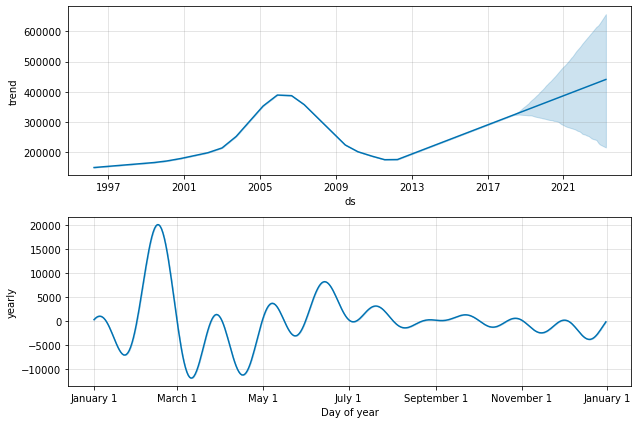

In [31]:
m.plot_components(forecast)

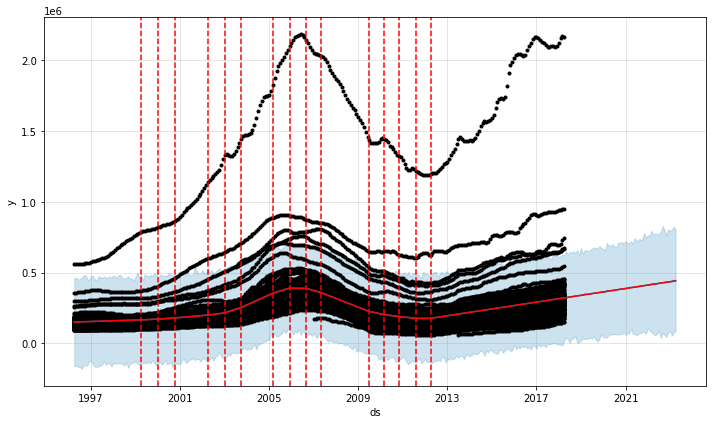

In [32]:
# Red lines represent detected changepoints 
from fbprophet.plot import add_changepoints_to_plot
a = add_changepoints_to_plot(fig1.gca(),m,forecast)
fig1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


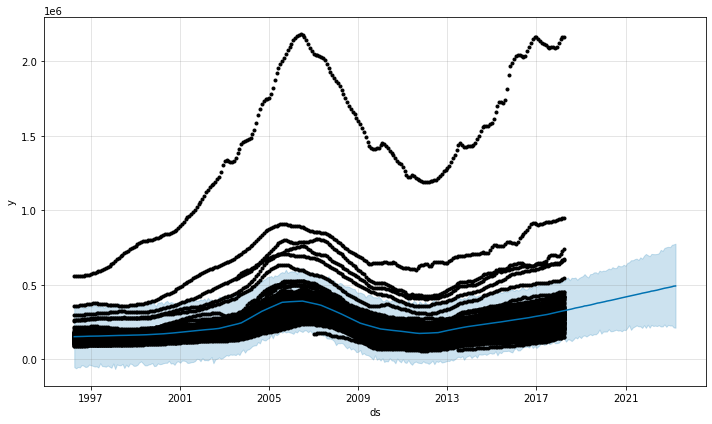

In [33]:
# Trying different parameters for the next 5 year predictions
m1 = Prophet(weekly_seasonality=False, changepoint_range=1, changepoint_prior_scale=0.75)
m1.fit(ts)

future1 = m1.make_future_dataframe(periods=60, freq='M')
forecast1 = m1.predict(future1)

fig2 = m1.plot(forecast1)

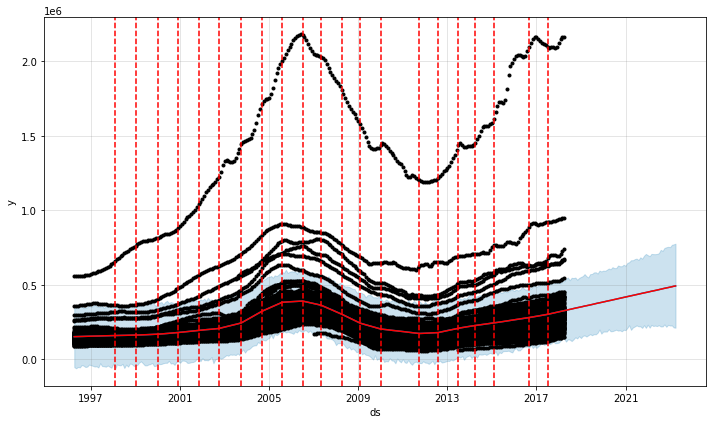

In [34]:
b = add_changepoints_to_plot(fig2.gca(),m1,forecast1)
fig2

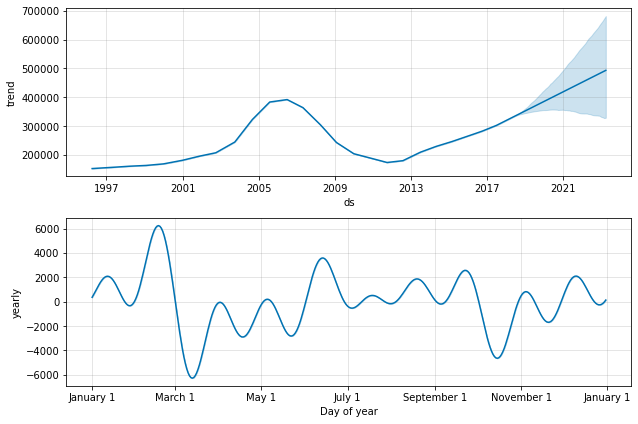

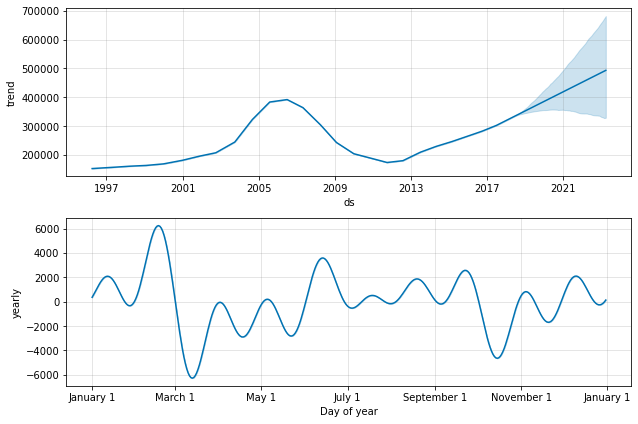

In [38]:
m1.plot_components(forecast1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


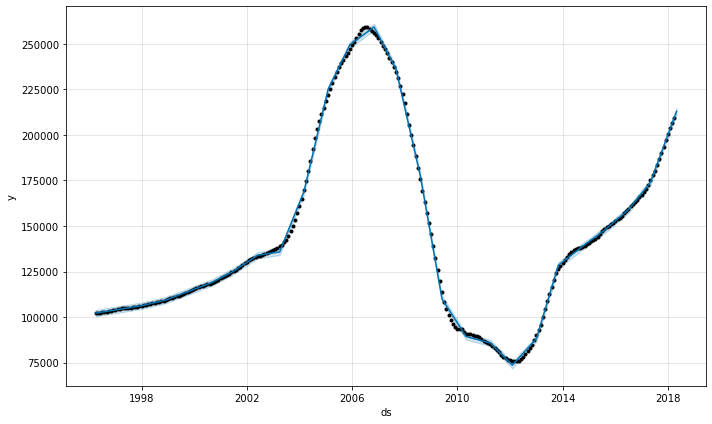

In [83]:
m2 = Prophet(yearly_seasonality=False, changepoint_range=1, changepoint_prior_scale=0.5)
m2.fit(ts)
 
future2 = m2.make_future_dataframe(periods=1, freq='M')
forecast2 = m2.predict(future2)

fig3 = m2.plot(forecast2)

In [84]:
forecast2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1996-04-01,102168.383553,100251.717875,103978.269798,102168.383553,102168.383553,0.0,0.0,0.0,0.0,0.0,0.0,102168.383553
1,1996-05-01,102360.343655,100474.873610,104138.684673,102360.343655,102360.343655,0.0,0.0,0.0,0.0,0.0,0.0,102360.343655
2,1996-06-01,102558.702426,100798.696901,104363.607219,102558.702426,102558.702426,0.0,0.0,0.0,0.0,0.0,0.0,102558.702426
3,1996-07-01,102750.662527,101051.492037,104546.129770,102750.662527,102750.662527,0.0,0.0,0.0,0.0,0.0,0.0,102750.662527
4,1996-08-01,102949.021299,101095.202067,104752.627435,102949.021299,102949.021299,0.0,0.0,0.0,0.0,0.0,0.0,102949.021299
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,2018-01-01,200094.890429,198390.128661,201790.246131,200094.890429,200094.890429,0.0,0.0,0.0,0.0,0.0,0.0,200094.890429
262,2018-02-01,203424.682668,201678.018950,205223.830901,203424.682668,203424.682668,0.0,0.0,0.0,0.0,0.0,0.0,203424.682668
263,2018-03-01,206432.236949,204672.985410,208317.035436,206432.236949,206432.236949,0.0,0.0,0.0,0.0,0.0,0.0,206432.236949
264,2018-04-01,209762.029188,207996.229121,211509.654954,209762.029188,209762.029188,0.0,0.0,0.0,0.0,0.0,0.0,209762.029188


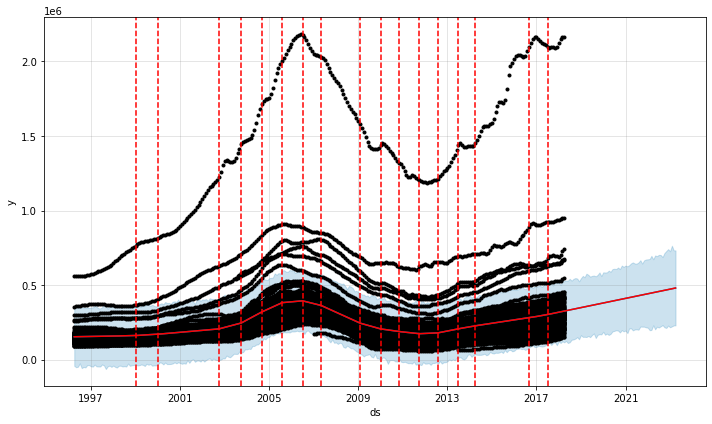

In [37]:
c = add_changepoints_to_plot(fig3.gca(),m2,forecast2)
fig3

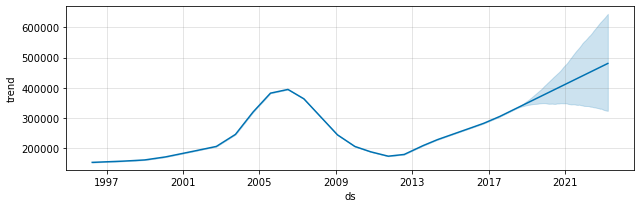

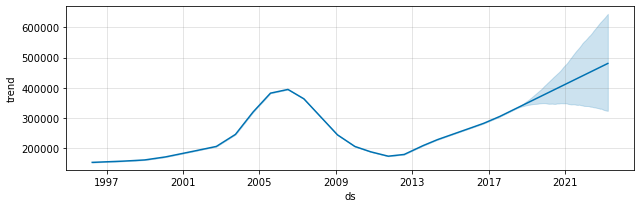

In [39]:
m2.plot_components(forecast2)

In [89]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m2, initial='6205 days', period='180 days', horizon = '365 days')


INFO:fbprophet:Making 9 forecasts with cutoffs between 2013-04-22 00:00:00 and 2017-04-01 00:00:00
100%|██████████| 9/9 [00:44<00:00,  4.99s/it]


In [90]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,40 days,7.146501e+06,2673.294076,2073.376930,0.016654,0.010564,0.5
1,43 days,8.268036e+06,2875.419358,2205.241648,0.017047,0.010564,0.5
2,45 days,1.042385e+07,3228.598757,2480.657797,0.018915,0.010564,0.5
3,48 days,9.098274e+06,3016.334538,2157.937044,0.016525,0.006943,0.6
4,50 days,9.453357e+06,3074.631125,2287.594269,0.017393,0.010564,0.5


In [91]:
np.mean(df_p['mape'])

0.048363877253920655

In [77]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
103,2017-12-01,182531.840889,175430.452452,189032.346319,197300.0,2017-04-01
104,2018-01-01,183923.670052,174916.298008,192251.234235,200700.0,2017-04-01
105,2018-02-01,185315.499216,174134.897617,194937.846932,203500.0,2017-04-01
106,2018-03-01,186572.635234,173418.864403,197955.737770,206600.0,2017-04-01
107,2018-04-01,187964.464397,172515.588794,201339.047313,209300.0,2017-04-01


## Prophet Model with all the Zipcodes in Denver 

The model below iterates over every zipcode in Denver and predecits the prices in May 2018. It cross validates the model fitted with 17 years of training data, one year of validation set (horizon) and the model makes predictions per zipcode for each year between 2013 and 2017. It returns average Mean Absolute Percentage Error (MAPE) for each zipcode.

In [119]:
a = list(zipcodes)[0:2]

[95744, 95750]

In [122]:
zipcodes = set(df_nv['RegionID'])
dict_mape = {}
dict_pred = {}
i = 1
for zipcode in zipcodes:
    # Create a new dataframe with dates and prices
    ts = pd.DataFrame({'ds':df_nv[df_nv['RegionID'] == zipcode].index, 'y':df_nv[df_nv['RegionID'] == zipcode]['value']})
    # Create a Prophet instance and fit the model
    m = Prophet(yearly_seasonality=False, changepoint_range=1, changepoint_prior_scale=0.5)
    m.fit(ts)

    # Create a dataframe holding dates for our forecast of one month period
    future = m.make_future_dataframe(periods=1, freq='M')
    # Create the forecast object which will hold all of the resulting data from the future.
    forecast = m.predict(future)

    # Fit the model with 17 years of training data, a horizon of 365 days (one year) and forecasting per year between 2013 and 2017
    df_cv = cross_validation(m, initial='6205 days', period='365 days', horizon = '365 days')
    df_p = performance_metrics(df_cv)

    # Create a dictionary with average MAPE of every zipcode
    dict_mape[zipcode] = np.mean(df_p['mape'])
    # Create a dictionary with forecasted prices of zipcodes for May 2018
    dict_pred[zipcode] = np.array(forecast2.yhat)[-1]
    print(f'iteration={i}')
    i += 1

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2013-04-02 00:00:00 and 2017-04-01 00:00:00
100%|██████████| 5/5 [00:51<00:00, 10.37s/it]
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=1


INFO:fbprophet:Making 5 forecasts with cutoffs between 2013-04-02 00:00:00 and 2017-04-01 00:00:00
100%|██████████| 5/5 [00:38<00:00,  7.68s/it]


iteration=2
